In [15]:
import os
import keras
import io
import csv
import time
import datetime

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dropout, SimpleRNN, LSTM, Bidirectional
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import keras_metrics
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D 

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import time


In [16]:
##Set params for the model
tensorBoard_logs_dir = '.\\logs\\'
model_dir = '.\\models\\'
glove_dir = '.\\models\\glove'
train_dir = '.\\data\\train'
train_data = 'messages_2.csv'
label_data = 'labels_2.csv'

maxlen = 100
training_samples = 2800
validation_samples = 500# len(labels) - training_samples #
max_words = 10000
num_filters = 64 
embedding_dim = 100
num_filters = 64 
num_classes = 3



In [3]:
texts = []
labels = []

with open(os.path.join(train_dir, train_data), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        texts.append(message)

with open(os.path.join(train_dir, label_data)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        labels.append(row)

labels = np.squeeze(labels)#[(np.squeeze(i)) for i in labels]
#np.squeeze(labels[:])
#la


In [4]:
(labels[0:10])

array(['0', '2', '2', '2', '2', '1', '2', '2', '2', '1'], dtype='<U1')

In [5]:
'''
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels,)
labells = np_utils.to_categorical(encoded_Y)
print(labells[0,])

'''
labells = np_utils.to_categorical(labels, num_classes=num_classes)
labells[0:20,]
np.sum(labells, axis = 0)

array([1121.,  303., 1765.], dtype=float32)

In [6]:
##Tokenizer, Sequencer and padding via Keras
np.random.seed(1) 

#tokenize the data for the maxwords
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

#Generate the sequences on texts on the the data by tokenizer
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))
#print(word_index)
#Padding sequences (making them all equal)
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of the data tensor:' , data.shape)
print('Shape of the label tensor:' , labells.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labells[indices,:]

x_train = data#[:training_samples]
y_train = labels#[:training_samples]
print(indices[0:10])
#x_test = data[training_samples:training_samples + validation_samples]
#y_test = labels[training_samples:training_samples + validation_samples]

print("Train length" , len(x_train))
#print("Test length" , len(x_test))


Found 6998 unique tokens.
Shape of the data tensor: (3189, 100)
Shape of the label tensor: (3189, 3)
[ 403  453 2534   13   45 2731 2009 2640  829  724]
Train length 3189


In [7]:
np.random.seed(1) 
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
   # print(word)
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()


print('Found %s word vectors' % len(embedding_index))

Found 400000 word vectors


In [8]:
np.random.seed(1) 
embedding_matrix = np.zeros((max_words, embedding_dim))
count = 0 
ignored_words = []
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            ignored_words.append(word)  
            count = count + 1
print(embedding_matrix.shape)       


(10000, 100)


In [ ]:
with open('.\\data\\final\\ignored_words.csv', mode='w') as words:
    writer = csv.writer(words, delimiter='\n', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerows([ignored_words])

In [9]:
def save_model(model_qualifier, model, location):
    model_name = model_qualifier + "-{}".format(datetime.date.today()) + "-{}".format(time.time())
    try:
        model.save(os.path.join(location, model_name))
        #plot_model(model, to_file=os.path.join(location, model_name)+ '.png')
    except:
        print("Exception occured while saving the model to disc.")

In [33]:
np.random.seed(1) 

model = Sequential() 
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
'''
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32))

model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(Dropout(0.7))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(Dropout(0.6))
model.add(GlobalMaxPooling1D())
'''
model.add(Bidirectional(LSTM(32, recurrent_dropout = 0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(32, recurrent_dropout = 0.2, return_sequences=True)))
#model.add(Bidirectional(LSTM(32, recurrent_dropout = 0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
#model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3, activation = 'softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True
model_name = "CodeMixed-Emb-BiLSTM_32x2_64x1_DO-Dense_64x2-{}".format(int(time.time()))
model.summary()

'''
model = load_model('.\\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5')
model_name = "CodeMixed-Emb-UnTrained-CNN_64x7x3_DO-Dense_64x1-{}".format(int(time.time()))

model.trainable = True
set_trainable = False
for layer in model.layers:
   # print(layer.name, ': ', layer.trainable)
    if layer.name in ['dense_27','dense_28', 'dense_29']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

for layer in model.layers:        
    print(layer.name, ': ', layer.trainable)

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

'''


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 64)           34048     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 100, 64)           24832     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)               

'\nmodel = load_model(\'.\\models\\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5\')\nmodel_name = "CodeMixed-Emb-UnTrained-CNN_64x7x3_DO-Dense_64x1-{}".format(int(time.time()))\n\nmodel.trainable = True\nset_trainable = False\nfor layer in model.layers:\n   # print(layer.name, \': \', layer.trainable)\n    if layer.name in [\'dense_27\',\'dense_28\', \'dense_29\']:\n        set_trainable = True\n    if set_trainable:\n        layer.trainable = True\n    else:\n        layer.trainable = False\n\nmodel.layers[0].set_weights([embedding_matrix])\nmodel.layers[0].trainable = False\n\nfor layer in model.layers:        \n    print(layer.name, \': \', layer.trainable)\n\nlayers = [(layer, layer.name, layer.trainable) for layer in model.layers]\npd.DataFrame(layers, columns=[\'Layer Type\', \'Layer Name\', \'Layer Trainable\'])   \n\n'

In [34]:
optimizer = Adam(learning_rate=0.01, decay=1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['acc'])


In [35]:
#callbacks 
earlystopping = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=40, restore_best_weights= True)

modelcheckpoint = ModelCheckpoint('.\\models\Best_Hinglish-Emb-BiLSTM_32x2_64x1_DO-Dense_64x2_model.h5', monitor='val_acc', mode='min', verbose=1)

reduce_lr_plateau = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


tensorboard = TensorBoard(log_dir = tensorBoard_logs_dir + '{}'.format(model_name), 
                         histogram_freq=1,
                         #embeddings_freq=1
                         )

In [36]:

tensorboard = TensorBoard(log_dir = tensorBoard_logs_dir + '{}'.format(model_name), 
                         histogram_freq=1,
                         #embeddings_freq=1
                         )
'''
TensorBoard(batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['features'],
                          embeddings_metadata='metadata.tsv',
                          embeddings_data=x_test)

'''

history = model.fit(x_train, y_train, epochs = 500, batch_size = 1024,validation_split=0.1, callbacks = [tensorboard, earlystopping, reduce_lr_plateau, modelcheckpoint])
#results = model.evaluate(x_test, y_test)
#model.save_weights(model_dir + '{}'.format(model_name)+'.h5')
save_model("CodeMixed-Emb-BiLSTM_32x2_64x1_DO-Dense_64x1_model", model, ".\\models")

C:\Users\vigupta\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 2870 samples, validate on 319 samples
Epoch 1/500
2870/2870 [==============================] - 680s 237ms/step - loss: 1.4193 - acc: 0.4080 - val_loss: 1.0114 - val_acc: 0.5831

Epoch 00001: saving model to .\models\Best_Hinglish-Emb-BiLSTM_32x2_64x1_DO-Dense_64x2_model.h5
Epoch 2/500
2870/2870 [==============================] - 651s 227ms/step - loss: 0.9384 - acc: 0.6328 - val_loss: 0.8326 - val_acc: 0.6865

Epoch 00002: saving model to .\models\Best_Hinglish-Emb-BiLSTM_32x2_64x1_DO-Dense_64x2_model.h5
Epoch 3/500
2870/2870 [==============================] - 618s 215ms/step - loss: 0.6953 - acc: 0.7446 - val_loss: 0.8719 - val_acc: 0.6301

Epoch 00003: saving model to .\models\Best_Hinglish-Emb-BiLSTM_32x2_64x1_DO-Dense_64x2_model.h5
Epoch 4/500
2870/2870 [==============================] - 785s 273ms/step - loss: 0.5519 - acc: 0.7965 - val_loss: 0.8497 - val_acc: 0.5799

Epoch 00004: saving model to .\models\Best_Hinglish-Emb-BiLSTM_32x2_64x1_DO-Dense_64x2_model.h5
Epoch 5/5

KeyboardInterrupt: 

In [89]:
results

[1.3130240078756925, 0.13881747424602509]

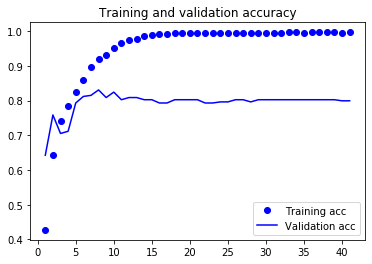

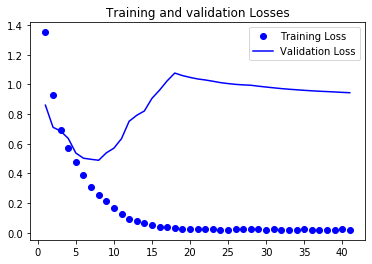

<Figure size 432x288 with 0 Axes>

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training Loss')
plt.plot(epochs, val_loss, 'b', label ='Validation Loss')
plt.title("Training and validation Losses")
plt.legend()
plt.figure()

plt.show()

In [24]:
print(model.metrics_names)
results

['loss', 'acc']


NameError: name 'results' is not defined

In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

weights[1:20, 0:10]

(10000, 100)


array([[ 5.8854e-01, -2.0250e-01,  7.3479e-01, -6.8338e-01, -1.9675e-01,
        -1.8020e-01, -3.9177e-01,  3.4172e-01, -6.0561e-01,  6.3816e-01],
       [ 2.5122e-02,  7.1667e-01, -5.2426e-01, -3.6750e-01,  4.3480e-01,
         1.4812e+00, -8.3414e-01, -6.8287e-01,  2.3824e-01,  1.2104e+00],
       [ 4.8565e-01, -1.7018e-01, -1.6144e-01, -2.1791e-01, -1.0460e-02,
         4.8495e-01,  6.7276e-02,  2.9462e-01,  3.1315e-01,  4.9928e-02],
       [-4.6539e-02,  6.1966e-01,  5.6647e-01, -4.6584e-01, -1.1890e+00,
         4.4599e-01,  6.6035e-02,  3.1910e-01,  1.4679e-01, -2.2119e-01],
       [ 2.5839e-01, -1.3339e-01,  2.7551e-01, -8.2961e-01, -4.8300e-01,
         7.1471e-01, -5.7770e-01, -7.8464e-01,  2.6379e-01, -2.6224e-01],
       [ 6.0587e-01,  2.7989e-02,  1.8495e-02, -1.8674e-02, -3.9562e-01,
         1.0309e+00, -3.5793e-01,  2.0527e-01,  3.2930e-01,  3.5267e-02],
       [-7.6304e-01,  7.4688e-01, -1.3438e-01,  3.7314e-01, -9.7820e-01,
         3.8362e-01,  4.6092e-01,  4.3544e-01

In [76]:
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

In [51]:
tsne_embeddings = TSNE(n_components=2).fit_transform(weights)
plot_words(tsne_embeddings, 0, 2, 1)

NameError: name 'word_list' is not defined